## Imports


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model


In [21]:
df = pd.read_csv("../noisy_gait_synth_data.csv")  # adjust path if needed
df.head()


,participant_id,time,group,walking_speed,sEMG_TA,sEMG_GM,sEMG_VL,sEMG_BF,sEMG_RF,ground_reaction_force
0,0,0.00000,SCI,0.490452,-0.055306,-0.232351,-0.210068,-0.281338,-0.155990,-28.830657
1,0,0.02004,SCI,0.489716,0.040567,0.482264,-0.382254,0.560597,0.159099,28.122569
2,0,0.04008,SCI,0.488981,0.694355,0.015144,0.675682,-0.288256,0.769657,49.855244
3,0,0.06012,SCI,0.488245,0.594982,0.291594,0.363988,0.028906,0.806068,159.872365
4,0,0.08016,SCI,0.487509,0.790292,0.470375,0.202701,0.484268,0.488469,192.164023


In [22]:
emg_cols = [col for col in df.columns if col.startswith("sEMG_")]
all_features = emg_cols + ["ground_reaction_force"]

# Encode SCI=1, Normal=0
df['group_encoded'] = LabelEncoder().fit_transform(df['group'])

# Normalize sEMG + GRF features
scaler = StandardScaler()
df[all_features] = scaler.fit_transform(df[all_features])


In [23]:
sequence_length = 50
step_size = 25

X, y = [], []

for pid in df['participant_id'].unique():
    df_p = df[df['participant_id'] == pid]
    features = df_p[all_features].values
    label = df_p['group_encoded'].iloc[0]

    for i in range(0, len(features) - sequence_length + 1, step_size):
        X.append(features[i:i + sequence_length])
        y.append(label)

X = np.array(X)
y = np.array(y)

X.shape, y.shape  # Check output shape


((950, 50, 6), (950,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [25]:
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\Natha\miniconda3\envs\emg_rnn_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7500 - loss: 0.5979 - val_accuracy: 1.0000 - val_loss: 0.1233
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9989 - loss: 0.0717 - val_accuracy: 1.0000 - val_loss: 0.0157
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 1.0000 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - v

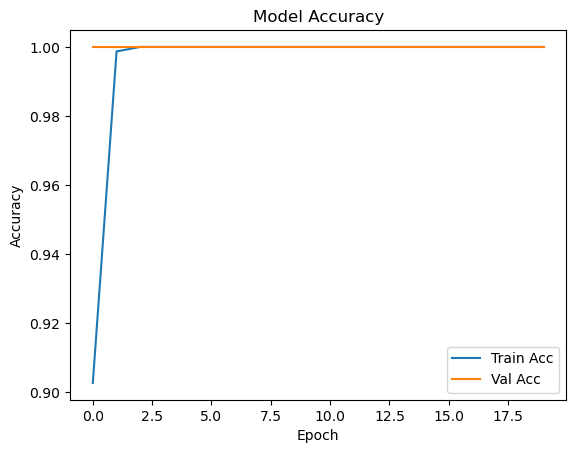

In [27]:
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [28]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.2f}")


Test Accuracy: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


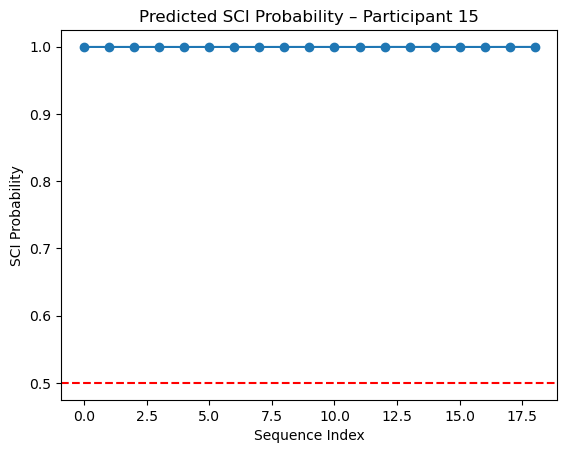

In [29]:
# Pick a random participant from the test set
test_pids = df[df['participant_id'].isin(df['participant_id'].unique())].groupby('participant_id').first()
test_pid = test_pids.sample(1).index.item()

# Extract sequences for that participant
df_p = df[df['participant_id'] == test_pid]
features = df_p[all_features].values
features = StandardScaler().fit_transform(features)  # ensure normalized

sequences = []
for i in range(0, len(features) - sequence_length + 1, step_size):
    sequences.append(features[i:i + sequence_length])
sequences = np.array(sequences)

# Predict
pred_probs = model.predict(sequences).flatten()
pred_labels = (pred_probs > 0.5).astype(int)

# Plot predictions over time
plt.plot(pred_probs, marker='o')
plt.axhline(0.5, linestyle='--', color='red')
plt.title(f"Predicted SCI Probability – Participant {test_pid}")
plt.xlabel("Sequence Index")
plt.ylabel("SCI Probability")
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 


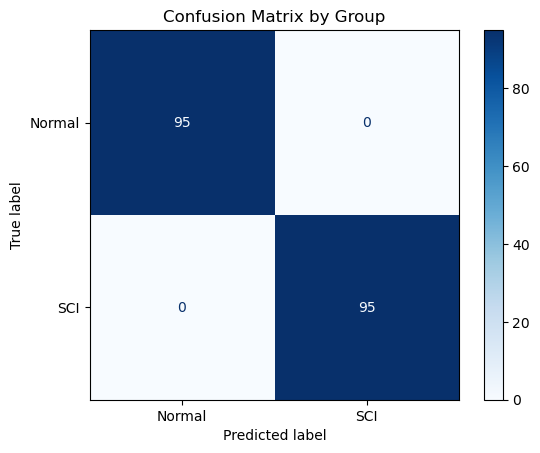

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "SCI"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix by Group")
plt.show()


In [31]:
# Reconstruct which test sequences belonged to which participant
# This assumes you still have df and participant info mapped to X/y
participant_ids = []

# Rebuild the index mapping by sequence from the original sliding window logic
for pid in df['participant_id'].unique():
    df_p = df[df['participant_id'] == pid]
    n_seq = (len(df_p) - sequence_length) // step_size + 1
    participant_ids.extend([pid] * n_seq)

# Keep only the test-set ones
_, X_test_pids = train_test_split(participant_ids, test_size=0.2, stratify=y, random_state=42)

# Compare predictions with true labels
for pid, true, pred in zip(X_test_pids, y_test, y_pred):
    if true != pred:
        print(f"❌ Misclassified participant {pid} | True: {true} → Predicted: {pred}")
